In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd

In [2]:
from ForestFlow.model_p3d_arinyo import ArinyoModel
from ForestFlow import model_p3d_arinyo

from lace.cosmo.camb_cosmo import get_cosmology
from ForestFlow.archive import GadgetArchive3D
from ForestFlow.plots_v0 import plot_test_p3d
from ForestFlow.P3D_cINN import P3DEmulator

In [3]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder

path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/global/u1/l/lcabayol/P3D/ForestFlow/


In [4]:
def sort_dict(dct, keys):
    """
    Sort a list of dictionaries based on specified keys.

    Args:
        dct (list): List of dictionaries to be sorted.
        keys (list): List of keys to sort the dictionaries by.

    Returns:
        list: The sorted list of dictionaries.
    """
    for d in dct:
        sorted_d = {
            k: d[k] for k in keys
        }  # create a new dictionary with only the specified keys
        d.clear()  # remove all items from the original dictionary
        d.update(
            sorted_d
        )  # update the original dictionary with the sorted dictionary
    return dct


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
from matplotlib import rcParams
import corner
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

# Temporary functions 

In [7]:
def get_condition(test_data):
    condition = [
        {
            key: value
            for key, value in test_data[i].items()
            if key in Archive3D.emu_params
        }
        for i in range(len(test_data))
    ] 
    
    condition = p3d_emu._sort_dict(
                condition, Archive3D.emu_params) 
    condition = [list(condition[i].values()) for i in range(len(condition))]
    condition = np.array(condition)
    
    return condition

In [8]:
def get_covariance(x,y):
    cov =  1/ (len(x)-1) * np.einsum('ij,jk ->ik',(x - y[None,:]).T,(x - y[None,:]))
    corr =np.corrcoef(cov)
    return cov, corr

# LOAD DATA

In [29]:
%%time
folder_lya_data = path_program +  "/data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1], 
    folder_data=folder_lya_data, 
    force_recompute_plin=False,
    average='both'
)
print(len(Archive3D.training_data))


1650
CPU times: user 15.1 s, sys: 1.35 s, total: 16.5 s
Wall time: 16.7 s


In [30]:
Archive3D.testing_data = Archive3D.get_testing_data(
    "mpg_central", force_recompute_plin=True
)

In [11]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    lr=0.001,#0.005
    batch_size=20,
    step_size=200,
    gamma=0.1,
    weight_decay=0,
    adamw=True,
    nLayers_inn=12,#15
    Archive=Archive3D,
    use_chains=False,
    chain_samp=100_000,
    grad_clip_threshold = 1e25,
    input_space='Arinyo',
    folder_chains='/data/desi/scratch/jchavesm/p3d_fits_new/'
)


Emualtor optimized in 256.21653270721436 seconds


fit {'bias': -0.4933550259779108, 'beta': 0.6304138107965037, 'q1': 0.8939264172249226, 'kvav': 1.4516999593931303, 'av': 0.6720122899185674, 'bv': 2.0066424695488343, 'kp': 16.46818037531716, 'q2': 0.32923518595805235}
emu {'bias': 0.4980439692735672, 'beta': 0.5951902568340302, 'q1': 0.8879405558109283, 'kvav': 1.5339787006378174, 'av': 0.6824887692928314, 'bv': 1.9761084914207458, 'kp': 16.14115810394287, 'q2': 0.2649303525686264}


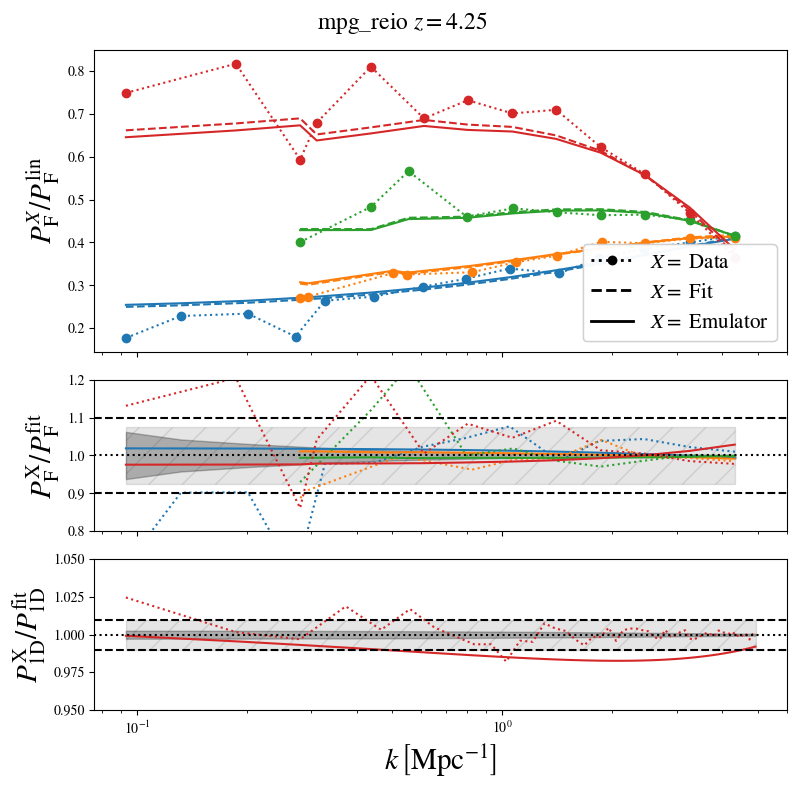

In [28]:
sim_label = "mpg_reio"
ind_book = 1
plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

## Arinyo redshift evolution

In [13]:
central = Archive3D.get_testing_data(sim_label='mpg_central')

In [14]:
condition_central = [
    {
        key: value
        for key, value in central[i].items()
        if key in Archive3D.emu_params
    }
    for i in range(len(central))
]

In [15]:
condition_central = sort_dict(
            condition_central, Archive3D.emu_params) 
condition_central = [list(condition_central[i].values()) for i in range(len(condition_central))]
condition_central = np.array(condition_central)


In [16]:
Arinyo_coeffs_central =  np.array( [list(central[i]["Arinyo"].values()) for i in range(len(central))] )

In [17]:
condition_central = torch.Tensor(condition_central)
#Arinyo_coeffs_central = torch.Tensor(Arinyo_coeffs_central)

In [19]:
Arinyo_coeffs_central_emulator = np.zeros_like(Arinyo_coeffs_central)
for test_snap in range(len(condition_central)):
    Arinyo_preds, Arinyo_preds_mean = p3d_emu.get_coeff(condition_central[test_snap], 
                                                true_coeffs=Arinyo_coeffs_central[test_snap], 
                                                plot=False, 
                                                Nrealizations=100,
                                                return_all_realizations=True)
    
    Arinyo_coeffs_central_emulator[test_snap] = Arinyo_preds_mean
    
    



In [24]:
list(central[0]["Arinyo"])

['bias', 'beta', 'q1', 'kvav', 'av', 'bv', 'kp', 'q2']

In [30]:
Arinyo_coeffs_central[0,:].shape

(8,)

Text(0, 0.5, 'Arinyo Parameter')

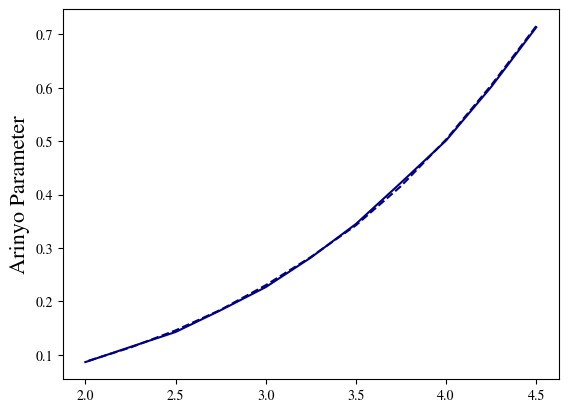

In [36]:
z_grid = np.flip(np.arange(2,4.6,0.25))
plt.plot(z_grid, np.abs(Arinyo_coeffs_central[:,0]), color = 'navy', ls = '-')
plt.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:,0]), color = 'navy', ls = '--')
plt.ylabel('Arinyo Parameter', fontsize = 16)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


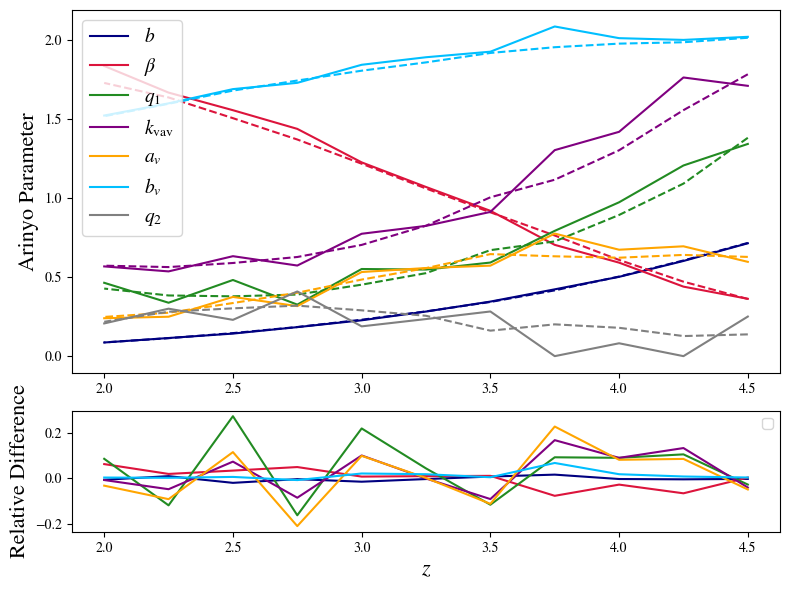

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Assuming Arinyo_coeffs_central and Arinyo_coeffs_central_emulator are defined

z_grid = np.flip(np.arange(2, 4.6, 0.25))

# Create a 2x1 grid for plotting
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Plot the original and emulator data in the upper panel
ax1 = plt.subplot(gs[0])
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 0]), color='navy', ls='-', label=r'$b$')
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 0]), color='navy', ls='--')

ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 1]), color='crimson', ls='-', label=r'$\beta$')
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 1]), color='crimson', ls='--')

ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 2]), color='forestgreen', ls='-', label=r'$q_1$')
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 2]), color='forestgreen', ls='--')

ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 3]), color='purple', ls='-', label=r'$k_{\rm vav}$')
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 3]), color='purple', ls='--')


ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 4]), color='orange', ls='-', label=r'$a_{v}$')
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 4]), color='orange', ls='--')

ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 5]), color='deepskyblue', ls='-', label=r'$b_{v}$')
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 5]), color='deepskyblue', ls='--')

#ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 6]), color='goldenrod', ls='-', label=r'$k_{p}$')
#ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 6]), color='goldenrod', ls='--')


ax1.plot(z_grid, np.abs(Arinyo_coeffs_central[:, 7]), color='grey', ls='-', label=r'$q_2$')
ax1.plot(z_grid, np.abs(Arinyo_coeffs_central_emulator[:, 7]), color='grey', ls='--')


ax1.set_ylabel('Arinyo Parameter', fontsize=16)
ax1.legend(fontsize=14)

# Calculate relative difference
relative_difference_bias = np.abs(Arinyo_coeffs_central[:, 0]) / np.abs(Arinyo_coeffs_central_emulator[:, 0]) - 1
relative_difference_beta = np.abs(Arinyo_coeffs_central[:, 1]) / np.abs(Arinyo_coeffs_central_emulator[:, 1]) - 1
relative_difference_q1 = np.abs(Arinyo_coeffs_central[:, 2]) / np.abs(Arinyo_coeffs_central_emulator[:, 2]) - 1
relative_difference_kvav = np.abs(Arinyo_coeffs_central[:, 3]) / np.abs(Arinyo_coeffs_central_emulator[:, 3]) - 1
relative_difference_av = np.abs(Arinyo_coeffs_central[:, 4]) / np.abs(Arinyo_coeffs_central_emulator[:, 4]) - 1
relative_difference_bv = np.abs(Arinyo_coeffs_central[:, 5]) / np.abs(Arinyo_coeffs_central_emulator[:, 5]) - 1
#relative_difference_kp = np.abs(Arinyo_coeffs_central[:, 6]) / np.abs(Arinyo_coeffs_central_emulator[:, 6])
relative_difference_q2 = np.abs(Arinyo_coeffs_central[:, 7]) / np.abs(Arinyo_coeffs_central_emulator[:, 7])


# Plot relative difference in the lower panel
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(z_grid, relative_difference_bias, color='navy', ls='-',)
ax2.plot(z_grid, relative_difference_beta, color='crimson', ls='-',)
ax2.plot(z_grid, relative_difference_q1, color='forestgreen', ls='-',)
ax2.plot(z_grid, relative_difference_kvav, color='purple', ls='-',)
ax2.plot(z_grid, relative_difference_av, color='orange', ls='-',)
ax2.plot(z_grid, relative_difference_bv, color='deepskyblue', ls='-',)
#ax2.plot(z_grid, relative_difference_kp, color='goldenrod', ls='-',)
#ax2.plot(z_grid, relative_difference_q2, color='grey', ls='-',)


ax2.set_xlabel('$z$', fontsize=16)
ax2.set_ylabel('Relative Difference', fontsize=16)
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('Arinyo_redshiftevolution.pdf', bbox_inches='tight')
plt.show()


In [26]:
z_grid

NameError: name 'z_grid' is not defined

## LOAD TEST DATA

In [121]:
central = Archive3D.get_testing_data(sim_label='mpg_central')

In [122]:
condition_central = [
    {
        key: value
        for key, value in central[i].items()
        if key in Archive3D.emu_params
    }
    for i in range(len(central))
]

In [123]:
condition_central = sort_dict(
            condition_central, Archive3D.emu_params) 
condition_central = [list(condition_central[i].values()) for i in range(len(condition_central))]
condition_central = np.array(condition_central)


In [124]:
condition_central

array([[ 0.18662703, -2.30005439,  0.21501432,  0.09836391,  1.43336711,
        14.73818602],
       [ 0.20466119, -2.30005442,  0.28793772,  0.10539599,  1.42760301,
        13.68824363],
       [ 0.22542656, -2.30005444,  0.36700435,  0.11256803,  1.43669446,
        12.84120199],
       [ 0.24949884, -2.3000544 ,  0.44734679,  0.11961106,  1.456119  ,
        12.13794324],
       [ 0.27761165, -2.30005434,  0.52375482,  0.12509012,  1.48042114,
        11.55744493],
       [ 0.31071097, -2.30005427,  0.59437185,  0.12684643,  1.4976862 ,
        11.06429924],
       [ 0.35003151, -2.30005452,  0.66041007,  0.12817464,  1.51217092,
        10.63483818],
       [ 0.39720634, -2.30005435,  0.71938457,  0.12913148,  1.52462549,
        10.25813427],
       [ 0.45442689, -2.30005451,  0.7711421 ,  0.1299304 ,  1.53546682,
         9.91377946],
       [ 0.5246786 , -2.30005446,  0.81471471,  0.13057073,  1.54498558,
         9.57454476],
       [ 0.61209474, -2.30005441,  0.85079832,  0.

In [125]:
Arinyo_coeffs_central =  np.array( [list(central[i]["Arinyo"].values()) for i in range(len(central))] )

In [126]:
condition_central = torch.Tensor(condition_central)
#Arinyo_coeffs_central = torch.Tensor(Arinyo_coeffs_central)

In [127]:
condition_central[test_snap].shape

torch.Size([6])

## TEST CENTRAL

In [128]:
test_snap=3

In [129]:
Arinyo_preds, Arinyo_preds_mean = p3d_emu.get_coeff(condition_central[test_snap], 
                                            true_coeffs=Arinyo_coeffs_central[test_snap], 
                                            plot=False, 
                                            Nrealizations=1000,
                                            return_all_realizations=True)



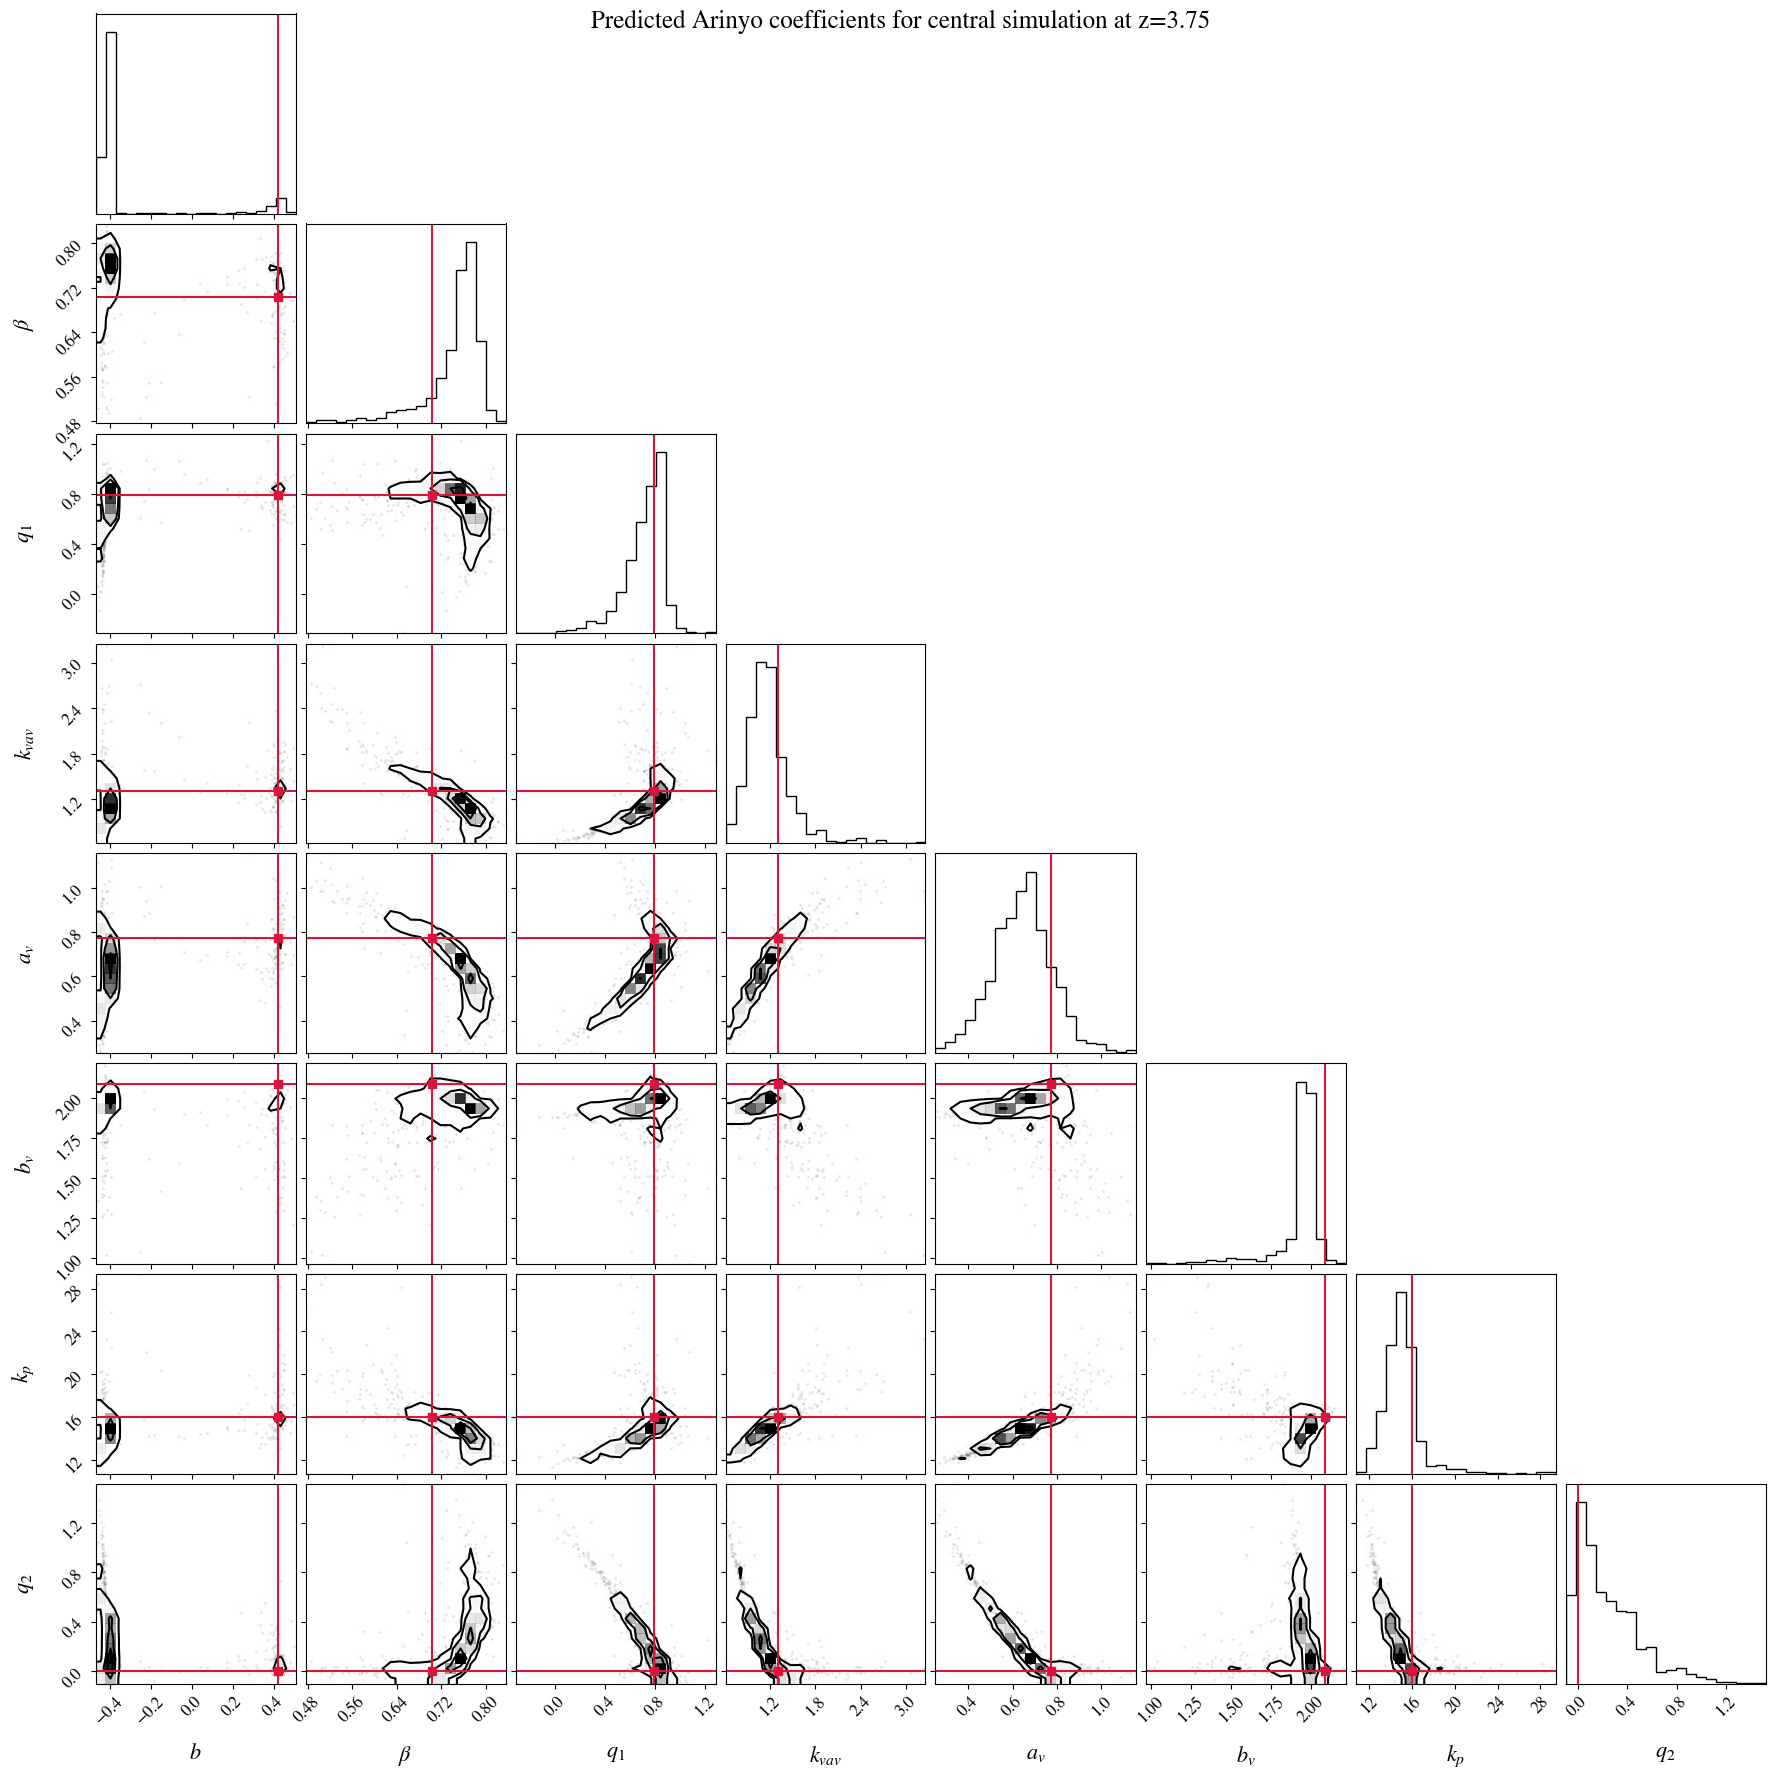

In [130]:
corner_plot = corner.corner(Arinyo_preds, 
              labels=[r'$b$', r'$\beta$', '$q_1$', '$k_{vav}$','$a_v$','$b_v$','$k_p$','$q_2$'], 
              truths=Arinyo_coeffs_central[test_snap],
              truth_color='crimson')


corner_plot.suptitle(f"Predicted Arinyo coefficients for central simulation at z={central[test_snap]['z']}", fontsize=18)
# Increase the label font size for this plot
for ax in corner_plot.get_axes():
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.set_tick_params(labelsize=12)  
    ax.yaxis.set_tick_params(labelsize=12)
plt.show()

## COVARIANCE

In [ ]:
def get_covariance(x,y):
    cov =  1/ (len(x)-1) * np.einsum('ij,jk ->ik',(x - y[None,:]).T,(x - y[None,:]))
    corr =np.corrcoef(cov)
    return cov, corr

In [31]:
central = Archive3D.get_testing_data(sim_label='mpg_central')

In [32]:
condition_central = [
    {
        key: value
        for key, value in central[i].items()
        if key in Archive3D.emu_params
    }
    for i in range(len(central))
]

In [33]:
condition_central = sort_dict(
            condition_central, Archive3D.emu_params) 
condition_central = [list(condition_central[i].values()) for i in range(len(condition_central))]
condition_central = np.array(condition_central)


In [34]:
Arinyo_coeffs_central =  np.array( [list(central[i]["Arinyo"].values()) for i in range(len(central))] )

In [35]:
condition_central = torch.Tensor(condition_central)


In [77]:
Arinyo_coeffs_mean_central_emulator= np.zeros_like(Arinyo_coeffs_central)
Arinyo_coeffs_central_emulator = np.zeros(shape=(11,1000,8))
for test_snap in range(len(condition_central)):
    Arinyo_preds, Arinyo_preds_mean = p3d_emu.get_coeff(condition_central[test_snap], 
                                                true_coeffs=Arinyo_coeffs_central[test_snap], 
                                                plot=False, 
                                                Nrealizations=1000,
                                                return_all_realizations=True)
    
    Arinyo_coeffs_mean_central_emulator[test_snap] = Arinyo_preds_mean
    Arinyo_coeffs_central_emulator[test_snap] = Arinyo_preds
    
    



In [97]:
def Arinyo_to_P3d(linP, k_Mpc, mu, params, epsilon=0.001, log_params=True):

    k = k_Mpc
    mu = mu


    bias, beta, q1, kvav, av, bv, kp, q2 = (
        params[:,0],
        params[:,1],
        params[:,2],
        params[:,3],
        params[:,4],
        params[:,5],
        params[:,6],
        params[:,7],
    )

    ## CALCULATE P3D
    print(av.shape, k.shape, kvav.shape, mu.shape, bv.shape)

    # model large-scales biasing for delta_flux(k)
    linear_rsd = 1 + beta[:,None] * mu[None,:]**2
    lowk_bias = bias[:,None]  * linear_rsd

    # model small-scales correction (D_NL in Arinyo-i-Prats 2015)
    delta2 = (1 / (2 * np.pi**2)) * k[None,:]**3 * linP
    nonlin = delta2 * (q1[:,None]  + q2[:,None]  * delta2)
    nonvel = ((k[None,:]**av[:,None] ) / kvav[:,None]) * mu[None,:]**bv[:,None] 
    nonpress = (k[None,:] / kp[:,None] ) ** 2

    D_NL = np.exp(nonlin * (1 - nonvel) - nonpress)

    p3d = linP * lowk_bias**2 * D_NL


    return p3d


In [109]:
mu.shape, k_Mpc.shape, p3d_pred.shape, k_masked.shape, mu_mask.shape

((20, 16), (20, 16), (1000, 17), (17,), (20, 16))

In [112]:
#p3d_uncertainty = np.zeros_like(p3ds_pred)
mu_lims = [0,0.06,0.31,0.38,0.62,0.69, 0.94,1]
m=1
mu =central[0]["mu3d"]
k_Mpc = central[0]["k3d_Mpc"]
k_mask = (k_Mpc < 4) & (k_Mpc > 0)
mu_mask = (mu>mu_lims[2*m]) &( mu<mu_lims[2*m+1])
k_masked = k_Mpc[mu_mask]
mu_masked = mu[mu_mask]
Nz=11
Nrealizations=1000

cov_p3d_preds = np.zeros(shape = (Nz,len(k_masked),len(k_masked)))
corr_p3d_preds = np.zeros(shape = (Nz,len(k_masked),len(k_masked)))

Plin = [ d['Plin'] for d in central]
Plin = np.array(Plin)


#Arinyos = Arinyo_coeffs_central_emulator[ii]


p3d_preds = np.zeros(shape = (Nz,Nrealizations, len(k_masked)))

for ii in range(11):
    Plin_test = Plin[ii][mu_mask]
    
    
    p3d_pred = Arinyo_to_P3d(Plin_test[ii],k_masked, mu_masked, Arinyo_coeffs_central_emulator[ii,:], epsilon=0.001)
    #p3d_pred = p3d_pred[:,mu_mask]
    p3d_preds[ii] = p3d_pred
    assert False

    #p3d_chain = Arinyo_to_P3d(Plin_test, k_Mpc, mu, Arinyos_chain[n], epsilon=0.001)
    #p3d_chain = p3d_chain[mu_mask]
    #p3d_chains[n] = p3d_chain




p3d_pred_cov, p3d_pred_corr = get_covariance(p3d_preds,p3d_preds.mean(0))
p3d_chain_cov, p3d_chain_corr = get_covariance(p3d_chains,p3d_chains.mean(0))

cov_p3d_preds[ii] =  p3d_pred_cov      
#cov_p3d_chains[s,ii] =  p3d_chain_cov       

corr_p3d_preds[ii] =  p3d_pred_corr      
#corr_p3d_chains[s,ii] =  p3d_chain_corr       





(1000,) (17,) (1000,) (17,) (1000,)


/tmp/ipykernel_130902/2189960555.py:31: RuntimeWarning: overflow encountered in exp
  D_NL = np.exp(nonlin * (1 - nonvel) - nonpress)
/tmp/ipykernel_130902/2189960555.py:33: RuntimeWarning: overflow encountered in multiply
  p3d = linP * lowk_bias**2 * D_NL


AssertionError: 

In [115]:
p3d_preds[0]

array([[51.81397996, 52.51634723, 90.20704686, ...,  0.        ,
         0.        ,  0.        ],
       [52.67575046, 53.44506509, 93.14837343, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.48705511,  4.54874417,  7.87903304, ...,         inf,
                inf,         inf],
       ...,
       [51.15215467, 51.94631146, 95.48689726, ...,  0.        ,
         0.        ,  0.        ],
       [52.26450835, 53.05170228, 94.76706801, ...,  0.        ,
         0.        ,  0.        ],
       [51.61894606, 52.17955385, 83.90965065, ...,         inf,
                inf,         inf]])